In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 4*x**2 - 3*x + 5

In [ ]:
f(3.0)

32.0

In [ ]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
ys

array([120. , 109.5,  99.5,  90. ,  81. ,  72.5,  64.5,  57. ,  50. ,
        43.5,  37.5,  32. ,  27. ,  22.5,  18.5,  15. ,  12. ,   9.5,
         7.5,   6. ,   5. ,   4.5,   4.5,   5. ,   6. ,   7.5,   9.5,
        12. ,  15. ,  18.5,  22.5,  27. ,  32. ,  37.5,  43.5,  50. ,
        57. ,  64.5,  72.5,  81. ])

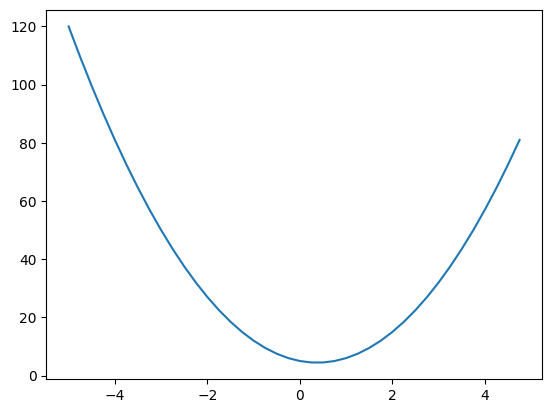

In [ ]:
plt.plot(xs,ys)

In [ ]:
 class Value:

    def __init__(self,data, _children=(),_op='',label=''):
      self.data = data
      self.grad = 0.0
      self._backward = lambda: None
      self._prev = set(_children)
      self._op = _op
      self.label = label

    def __repr__(self):
      return f"value(data={self.data})"

    def __add__(self,other):
      other  = other if isinstance(other,Value) else Value(other)
      out = Value(self.data + other.data,(self,other),'+')

      def _backward():
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * out.grad
      out._backward = _backward

      return out

    def __mul__(self,other):
      other  = other if isinstance(other,Value) else Value(other)

      out = Value(self.data * other.data,(self,other),'*')

      def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
      out._backward = _backward

      return out

    def __pow__(self,other):
      assert isinstance(other,(int,float)), "only supporting int/float powers for now"
      out = Value(self.data**other,(self,),f'**{other}')

      def _backward():
        self.grad += (other * self.data**(other-1)) * out.grad
      out._backward = _backward

      return out

    def __rmul__(self,other):
      return self * other

    def __truediv__(self,other):
      return self * other**-1

    def __sub__(self,other):
      return self + (-other)

    def __neg__(self):
      return self * -1


    def tanh(self):
      n = self.data
      t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
      out = Value(t,(self,),'tanh')

      def _backward():
        self.grad += (1-t**2) * out.grad
      out._backward = _backward

      return out

    def exp(self):
      x = self.data
      out = Value(math.exp(x),(self, ),'exp')

      def _backward():
        self.grad += out.data * out.grad
      out._backward = _backward

      return out


    def backward(self):
        """Computes gradients using backpropagation."""
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0  # Initialize gradient for the final node
        for node in reversed(topo):
            node._backward()




In [ ]:
a = Value(9.0)
b = Value(4.0)
a - b

value(data=5.0)

In [ ]:
from graphviz import Digraph

def trace(root):
  nodes,edges = set(),set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dpt = Digraph(format='svg',graph_attr={'rankdir':'LR'})

  nodes,edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dpt.node(name=uid,label="{%s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad),shape='record')
    if n._op:
      dpt.node(name=uid+n._op,label=n._op)
      dpt.edge(uid+n._op,uid)

  for n1,n2 in edges:
    dpt.edge(str(id(n1)),str(id(n2))+n2._op)
  return dpt


In [ ]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

b = Value(6.8813735870195432,label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label ='o'
o.backward()

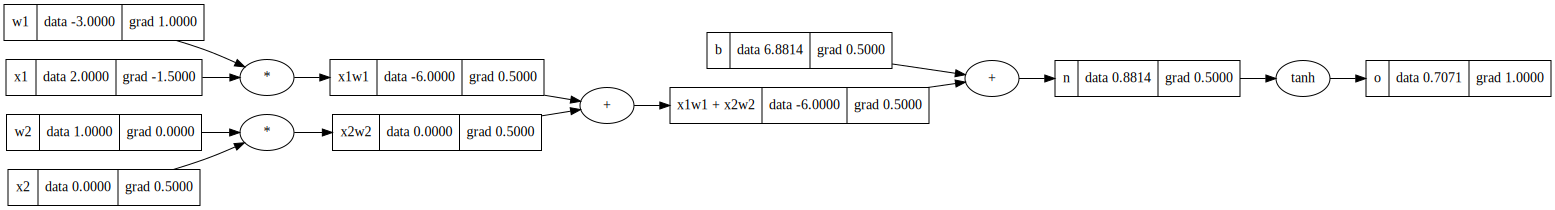

In [ ]:
draw_dot(o)

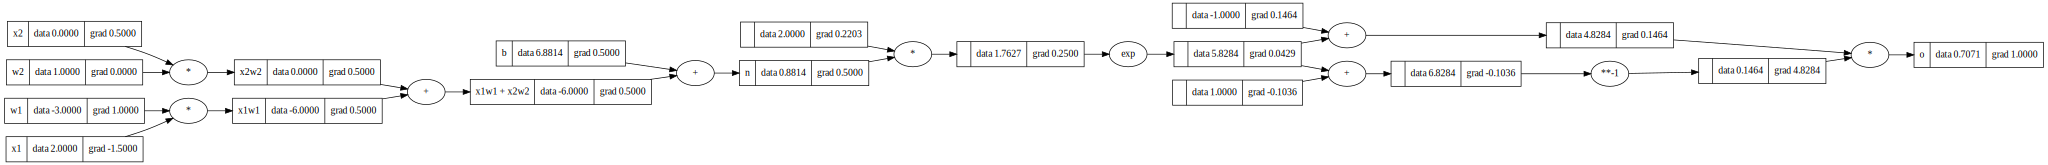

In [ ]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

b = Value(6.8813735870195432,label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e-1)/(e+1)
o.label ='o'
o.backward()
draw_dot(o)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [ ]:
x = [2.0 ,3.0,-1]
n = MLP(3,[4,4,1])
n(x)

value(data=0.5946539909470252)

In [ ]:
n.parameters()

[value(data=0.11586251923677615),
 value(data=0.2139630829894319),
 value(data=-0.7493576219922333),
 value(data=-0.16923678989695512),
 value(data=0.5579482354029559),
 value(data=0.41335349335110716),
 value(data=-0.3456667178061612),
 value(data=-0.6595780881317586),
 value(data=-0.9636373637824689),
 value(data=-0.3272459531627694),
 value(data=-0.450448705535335),
 value(data=-0.5186687845008404),
 value(data=0.2705565864300039),
 value(data=-0.3744126043897127),
 value(data=0.9364312051535362),
 value(data=0.5158578462939332),
 value(data=-0.15347572966562062),
 value(data=-0.07798993680836697),
 value(data=0.12120786836949149),
 value(data=0.01014182702692712),
 value(data=0.13695060790403213),
 value(data=0.3967674399762606),
 value(data=-0.33775989435766585),
 value(data=-0.005166655603793924),
 value(data=0.4109732078549342),
 value(data=0.6193407234082751),
 value(data=-0.0762538854449335),
 value(data=-0.47353980273204366),
 value(data=0.46226445847479725),
 value(data=-0.6

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]


In [ ]:
import numpy as np

for k in range(30):
  ypred = [n(x) for x in xs]
  loss = np.sum(np.array([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)]))

  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k,loss.data)


0 0.009703724722027079
1 0.009304700472792337
2 0.008936584304158016
3 0.008595943542800478
4 0.008279833948177854
5 0.007985715993571405
6 0.007711387774982098
7 0.007454930821458729
8 0.007214666004729027
9 0.0069891174202350425
10 0.006776982608797356
11 0.006577107858360306
12 0.006388467603589228
13 0.006210147152165018
14 0.006041328128024803
15 0.005881276146183184
16 0.0057293303303307536
17 0.0055848943598925515
18 0.00544742879262588
19 0.005316444455865155
20 0.00519149673697843
21 0.005072180633600512
22 0.004958126448363994
23 0.004848996032401425
24 0.004744479497791243
25 0.004644292332111069
26 0.004548172858924316
27 0.004455879996811166
28 0.004367191276827222
29 0.004281901084312677


In [ ]:
ypred

[value(data=0.982567485383922),
 value(data=-0.9651202227967401),
 value(data=-0.9601091091123894),
 value(data=0.9657928883868192)]